In [ ]:
!nvidia-smi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd

from hvsrUNet.module.GPRNet import GPRNet
from hvsrUNet.toolbox.smooth import smooth
%matplotlib inline

In [2]:
datasets_4 = np.load('datasets_4.npz')
disp_4 = datasets_4['disp']
hvsr_4 = datasets_4['HVSR']
VVs_4 = datasets_4['VVs']
depth_4 = datasets_4['Depth']

datasets_3 = np.load('datasets_3.npz')
disp_3 = datasets_3['disp']
hvsr_3 = datasets_3['HVSR']
VVs_3 = datasets_3['VVs']
depth_3 = datasets_3['Depth']

disp = np.concatenate((disp_4, disp_3), axis=0)
hvsr = np.concatenate((hvsr_4, hvsr_3), axis=0)
VVs = np.concatenate((VVs_4, VVs_3), axis=0) / 1000.

X_train, X_test, y_train, y_test = train_test_split(hvsr, VVs, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'hvsr.shape: {hvsr.shape}')
print(f'VVs.shape: {VVs.shape}')
print(f'disp.shape: {disp.shape}')

hvsr.shape: (7466, 512)
VVs.shape: (7466, 512)
disp.shape: (7466, 512)


In [3]:
X_train = tf.expand_dims(X_train, axis=2)
y_train = tf.expand_dims(y_train, axis=2)
X_valid = tf.expand_dims(X_valid, axis=2)
y_valid = tf.expand_dims(y_valid, axis=2)
X_test = tf.expand_dims(X_test, axis=2)
y_test = tf.expand_dims(y_test, axis=2)

In [ ]:
np.random.seed(33)
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 100)

        x2 = np.linspace(0, 50, len(y_test[i, ...]))

        ax.plot(x2, X_test[i, ...], color='blue', label='True', linewidth=2.5)

        ax.set_xlabel('Freq [Hz]')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')

    fig.tight_layout()
    plt.show()

In [5]:
model = GPRNet(im_width=1, im_height=512, neurons=8, kern_sz=10,enable_dropout=False)
# model.summary()

In [6]:
name_checkpoint = 'checkpoints/hvsr_2023_10_07/Weights/{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/hvsr_2023_10_07/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/hvsr_2023_10_07/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 1000
n_batches = len(X_train) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=10*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit(X_train, y_train,
          validation_data=[X_valid,y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

Epoch 1/1000


2023-10-07 22:31:49.249016: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:49.249146: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:49.256262: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:49.256374: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

148/150 [============================>.] - ETA: 0s - loss: 0.0439 - mae: 0.1407 - mse: 0.0439 - R2_score: 0.3963

2023-10-07 22:31:54.228675: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:54.228770: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:54.281880: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-07 22:31:54.282002: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

150/150 [==============================] - 13s 42ms/step - loss: 0.0436 - mae: 0.1401 - mse: 0.0436 - R2_score: 0.4025 - val_loss: 0.0110 - val_mae: 0.0785 - val_mse: 0.0110 - val_R2_score: 0.8476 - lr: 1.0000e-04
Epoch 2/1000
150/150 [==============================] - 5s 33ms/step - loss: 0.0098 - mae: 0.0722 - mse: 0.0098 - R2_score: 0.8653 - val_loss: 0.0084 - val_mae: 0.0646 - val_mse: 0.0084 - val_R2_score: 0.8844 - lr: 1.0000e-04
Epoch 3/1000
150/150 [==============================] - 5s 33ms/step - loss: 0.0078 - mae: 0.0618 - mse: 0.0078 - R2_score: 0.8925 - val_loss: 0.0074 - val_mae: 0.0604 - val_mse: 0.0074 - val_R2_score: 0.8982 - lr: 1.0000e-04
Epoch 4/1000
150/150 [==============================] - 5s 34ms/step - loss: 0.0069 - mae: 0.0564 - mse: 0.0069 - R2_score: 0.9059 - val_loss: 0.0066 - val_mae: 0.0563 - val_mse: 0.0066 - val_R2_score: 0.9084 - lr: 1.0000e-04
Epoch 5/1000
150/150 [==============================] - 5s 33ms/step - loss: 0.0062 - mae: 0.0523 - mse: 0.0

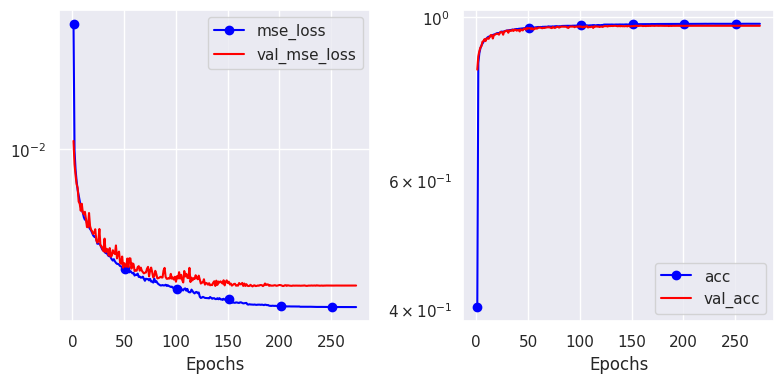

In [7]:
training_log = pd.read_csv('checkpoints/hvsr_2023_10_07/Logs/disp.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

value = [mse_loss, val_mse_loss, acc, val_acc]
name = ['mse_loss', 'val_mse_loss', 'acc', 'val_acc']

epochs = range(1, len(acc) + 1)

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for i, ax in enumerate(axes):

        ax.plot(epochs, value[2*i], label=name[2*i], marker='o', color='blue', markevery=50)
        ax.plot(epochs, value[2*i+1], label=name[2*i+1], color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.legend()
        #ax.set_title(name)
    
    plt.tight_layout()

plt.show()
    

In [ ]:
model.load_weights('checkpoints/hvsr_2023_10_07//Weights/0150.keras')

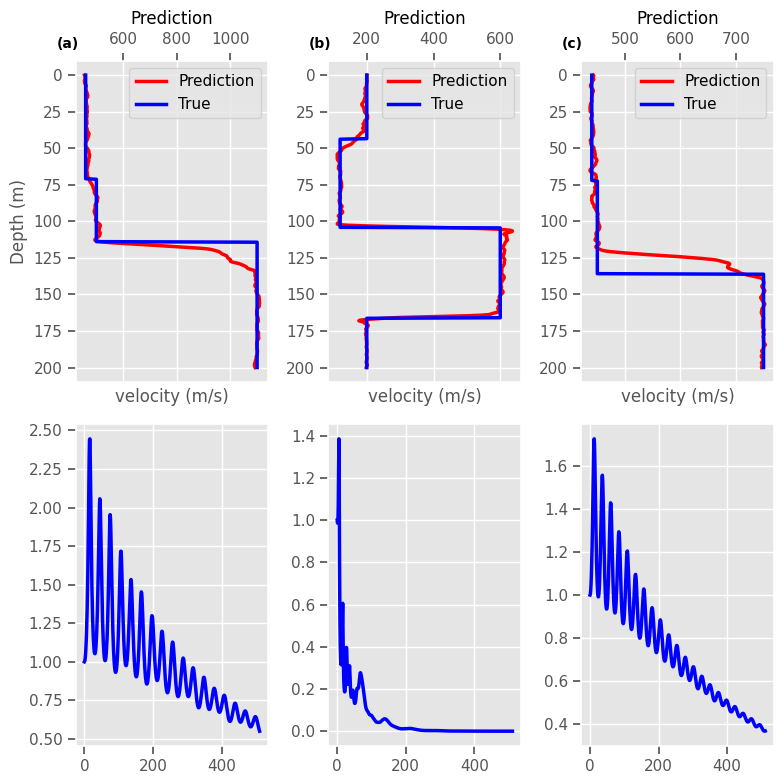

In [12]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(2, 3, figsize=(8, 8))
    fig = plt.figure()
    ax1 = plt.subplot(2, 3, 1)
    
    for j, ax in enumerate(axes[0].flat):

        i = np.random.randint(0, 150)
        ypred = model.predict(X_test[i:i+1, ...])
        yy = smooth(np.squeeze(ypred), window_len=10, window='blackman')
        depth1 = np.linspace(0, 200, len(yy))
        depth2 = np.linspace(0, 200, len(y_test[i, ...]))

        ax.plot(yy*1000, depth1, label='Prediction', color='red', linewidth=2.5)
        ax.plot(np.squeeze(y_test[i, ...])*1000, depth2, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
        axes[1, j].plot(X_test[i, ...], color='blue', label='True', linewidth=2.5)
    axes[0, 0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()

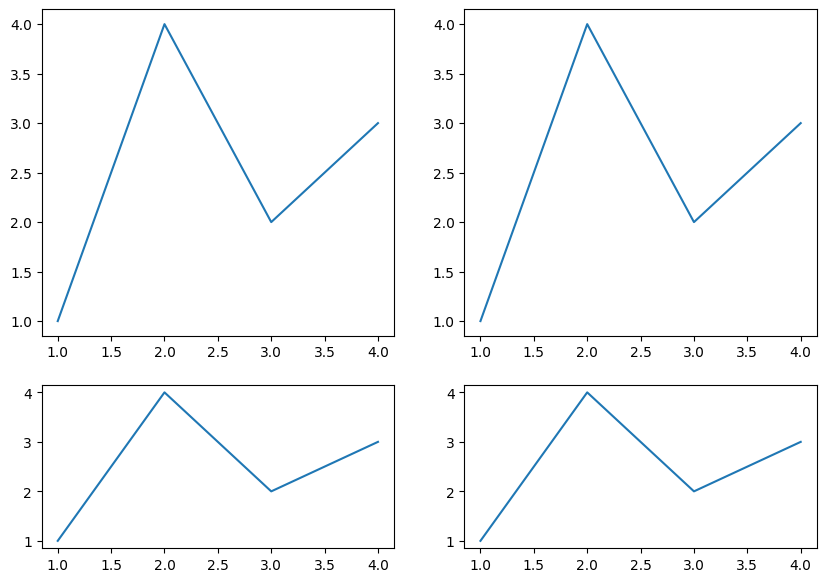

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 创建包含多个子图的图形，设置子图布局
fig = plt.figure(figsize=(10, 7))
spec = gridspec.GridSpec(2, 2, height_ratios=[6, 3], width_ratios=[4, 4])

# 第一行第一列子图，大小为 (8, 4)
ax1 = fig.add_subplot(spec[0, 0])

# 第一行第二列子图，大小为 (1, 4)，占据整个第一行高度
ax2 = fig.add_subplot(spec[0, 1])

# 第二行第一列子图，大小为 (8, 3)
ax3 = fig.add_subplot(spec[1, 0])

# 第二行第二列子图，大小为 (1, 3)，占据整个第二行高度
ax4 = fig.add_subplot(spec[1, 1])

# 在子图上绘制内容
ax1.plot([1, 2, 3, 4], [1, 4, 2, 3])
ax2.plot([1, 2, 3, 4], [1, 4, 2, 3])
ax3.plot([1, 2, 3, 4], [1, 4, 2, 3])
ax4.plot([1, 2, 3, 4], [1, 4, 2, 3])

# 显示图形
plt.show()
